# **ТРЕТЬЯ ЧАСТЬ  -  LGBMRegressor'**

---

*   На основе данных в файле train.csv научить модель, которая по любым параметрам из файла будет предсказывать колонку revenue_30d_total.
*   Цель: максимально точно предсказать это значение.
*   Метрика контроля качества: относительная ошибка на каждом пользователе:(predicted_revenue_30d_total - revenue_30d_total) / revenue_30d_total
*   Можно пользоваться любыми фреймворками и типами моделей. Но желательно объяснить выбор того или иного инструмента. 



# **ИМПОРТ БИБЛИОТЕК**

---

In [1]:
from matplotlib import pyplot
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as stats


from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split, cross_validate, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_squared_error

import pickle
!pip install scipy==1.7.1
import time
import sys
import os
import warnings
warnings.filterwarnings('ignore')



from jupyterthemes import jtplot
jtplot.style(context='notebook', ticks=True, grid=False)

!pip install lightgbm
import lightgbm as lgb

# **ЗАГРУЗКА ФИН ДАТАСЕТ**


---

In [2]:
# подготовим абсолютный путь до папки с данными
path = os.path.expanduser('~/PycharmProjects/Brightika_test/')
start = time.time() # включим таймер для подсчета времени чтения файла в датасет
train = pd.read_csv(path + 'train_out_outliers.csv')

In [3]:
train['revenue_30d_total'].describe().apply(lambda x: f'{x:0.8f}')

count    4125714.00000000
mean           0.17701312
std            0.93278879
min            0.00000000
25%            0.00350078
50%            0.01942773
75%            0.08062470
max          178.39592106
Name: revenue_30d_total, dtype: object

# ПОДГОТОВКА К МОДЕЛИРОВАНИЮ 

## Feature generation
Существуют различные способы повышения качества работы моделей машинного обучения.
Одним из таких способов является создание новых признаков. 
в блокноте 1 части я создала доп признаки 
1) install_date_month - месяц установки пользователем приложения (первый вход)
2) install_date_day -  день установки пользователем приложения (первый вход)
3) user_agent -  Android тип устройства из идентификационная строка клиентского приложения

создадим доп признак день недели
4) install_date_weekday - установка день недели
5) revenue_30d_total_median_per_os - медиана по выручке в зависимости от типа ОС
6) revenue_30d_total_median_per_lan - медиана по выручке в зависимости от типа языка
удалим все категор колонки, которые не будут учавствовать в моделировании
install_date
random_user_id

In [4]:
train['install_date'] = pd.to_datetime(train.install_date, utc=True)
train['install_date_weekday'] = train['install_date'].dt.weekday

lang_count = train.groupby('Android').agg(revenue_30d_total_median_per_os=('revenue_30d_total', np.median)).fillna(method='ffill').reset_index()
train = pd.merge(train, lang_count, how='left', on='Android')
train[['revenue_30d_total_median_per_os', 'revenue_30d_total']].head(3)

lang_count = train.groupby('Android').agg(revenue_30d_total_mean_per_os=('revenue_30d_total', np.mean)).fillna(method='ffill').reset_index()
train = pd.merge(train, lang_count, how='left', on='Android')
train[['revenue_30d_total_mean_per_os', 'revenue_30d_total']].head(3)

lang_count = train.groupby('language').agg(revenue_30d_total_median_per_lan=('revenue_30d_total', np.median)).fillna(method='ffill').reset_index()
train = pd.merge(train, lang_count, how='left', on='language')
train[['revenue_30d_total_mean_per_os', 'revenue_30d_total']].head(3)

lang_count = train.groupby('language').agg(revenue_30d_total_mean_per_lan=('revenue_30d_total', np.mean)).fillna(method='ffill').reset_index()
train = pd.merge(train, lang_count, how='left', on='language')
train[['revenue_30d_total_mean_per_lan', 'revenue_30d_total']].head(3)

In [5]:
# добавим новые фичи (частота встречаемости языка)
lan = train['language'].value_counts().reset_index().set_axis(['language', 'language_count'], axis=1)
train = pd.merge(train, lan, how='left', on='language')
train = train.drop(['install_date','random_user_id','Android', 'language'], axis=1)


In [6]:
def sqr_sqrt_log_features_transform(train: pd.DataFrame,
                                    sqr_miss: list=None,
                                    sqrt_miss: list=None,
                                    log_miss: list=None,
                                   ) -> pd.DataFrame:
    """
    Function transforms dataset adding squares, square roots and logarithm of numerical features
    
    :param df:  input data frame
    :sqr_miss:  columns, that should be missed for square feature generation
    :sqrt_miss: columns, that should be missed for square root feature generation
    :log_miss:  columns, that should be missed for logarithm feature generation
    
    :return:    dataframe with added features
    """
    
    df = train.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if ~np.isin(col, sqrt_miss):
            df[f'{col}_sqr'] = np.square(df[col])
        if ~np.isin(col, sqrt_miss):
            df[f'{col}_sqrt'] = np.sqrt(df[col])
        if ~np.isin(col, log_miss):
            df[f'{col}_log'] = np.log(df[col] + 0.01)    
    return df

In [7]:
train = sqr_sqrt_log_features_transform(train, 
                                       sqr_miss=['revenue_30d_total'],
                                       sqrt_miss=['revenue_30d_total'],
                                       log_miss=['revenue_30d_total'],
                                     )
train.shape

(4125714, 85)

# **НОРМАЛИЗАЦИЯ, СТАБИЛИЗАЦИЯ ДАННЫХ**
нормализация нужна, чтобы привезти данные к нормальному виду [0:1]
чтобы переменная не могла влиять на другую больше чем остальные


In [8]:

for_stand=train[['revenue_24h_rewards', 'revenue_24h_total', 'revenue_24h_banner', 'revenue_24h_inters',
'api_level', 'sessions_24h', 'screen_inches_diagonal', 'ad_views_24h_rewards', 'ad_views_24h_total',
'device_price', 'screen_pixels_width', 'conversion_duration']]


std_scaler = StandardScaler()
std_scaler
std_scaler.fit(for_stand)
print('Среднее:', std_scaler.mean_)
print('Дисперсия', std_scaler.var_)
std_scaled = std_scaler.transform(for_stand)



Среднее: [1.77753431e-02 7.46125017e-02 9.89730000e-03 4.69398585e-02
 2.92092191e+01 1.74585248e+00 6.46785221e+00 2.16965039e+00
 3.27863516e+01 1.69040147e+02 8.56888954e+02 1.11683903e+04]
Дисперсия [7.89970851e-03 7.46299150e-02 1.53894151e-03 3.17609296e-02
 3.17087290e+00 1.60188180e+00 3.51584997e-01 3.05335837e+01
 4.38762026e+03 7.03529090e+04 5.79864825e+04 5.60001961e+09]


In [9]:
# запишем новые значение стандартизированных данных (взяты из модели baseline после первой прогонки)
# это топ фич по вкладу в модель
train[['revenue_24h_total_std', 'revenue_24h_banner_std', 'revenue_24h_inters_std',
        'revenue_24h_rewards_std', 'ad_views_24h_total_std',
        'ad_views_24h_rewards_std', 'sessions_24h_std',
        'conversion_duration_std', 'api_level_std', 'device_price_std',
        'screen_inches_diagonal_std','screen_pixels_width_std'
        ]] = std_scaled  


# LGBMRegressor
## train-test split
это фреймворк, который предоставляет реализацию деревьев принятия решений с градиентным бустингом.


In [10]:
train_no_revenue_tree=train.drop(['revenue_30d_total'], axis=1)
train_no_revenue_tree.shape
X=train_no_revenue_tree
y=train['revenue_30d_total']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

# Оценка точности модели
training's l2: 0.506018	valid_1's l2: 0.535431
кач-во чуть лучше чем на тестовой

In [11]:
lgb_params = {"n_estimators": 500,
               "max_depth": 5,
               "n_jobs": -1,
               "random_state": 128,
              }

lgb = lgb.LGBMRegressor(**lgb_params)
lgb.fit(x_train, y_train,
              early_stopping_rounds=20, 
              eval_set=[(x_train, y_train), (x_test, y_test)],
              verbose=15)
gb_std = np.sqrt(mean_squared_error(y_train, lgb.predict(x_train)))
gb_std

[15]	training's l2: 0.506018	valid_1's l2: 0.535431
[30]	training's l2: 0.479331	valid_1's l2: 0.512011
[45]	training's l2: 0.471175	valid_1's l2: 0.509131
[60]	training's l2: 0.465337	valid_1's l2: 0.508848


0.683937737108736

In [12]:
# выведем features и отсортируем по убыванию, чтобы понять, какие фичи вносят больший результат
lgb.feature_importances_
f_imp_list = list(zip(X.columns, lgb.feature_importances_))
f_imp_list.sort(key = lambda x: x[1], reverse=True)
f_imp_list=pd.DataFrame({"features": X.columns, "feature_importances": lgb.feature_importances_})
f_imp_list['feature_importances'].describe()

count     96.000000
mean      15.583333
std       30.722756
min        0.000000
25%        0.000000
50%        0.000000
75%       18.250000
max      169.000000
Name: feature_importances, dtype: float64

In [13]:
# обрежем features, которые имеют вклад 0 в модель, ушло 45 features 
f_imp_list_cut = f_imp_list.loc[f_imp_list['feature_importances']>0, :]
f_imp_list_cut['feature_importances'].describe()

count     37.000000
mean      40.432432
std       38.186342
min        1.000000
25%       13.000000
50%       32.000000
75%       56.000000
max      169.000000
Name: feature_importances, dtype: float64

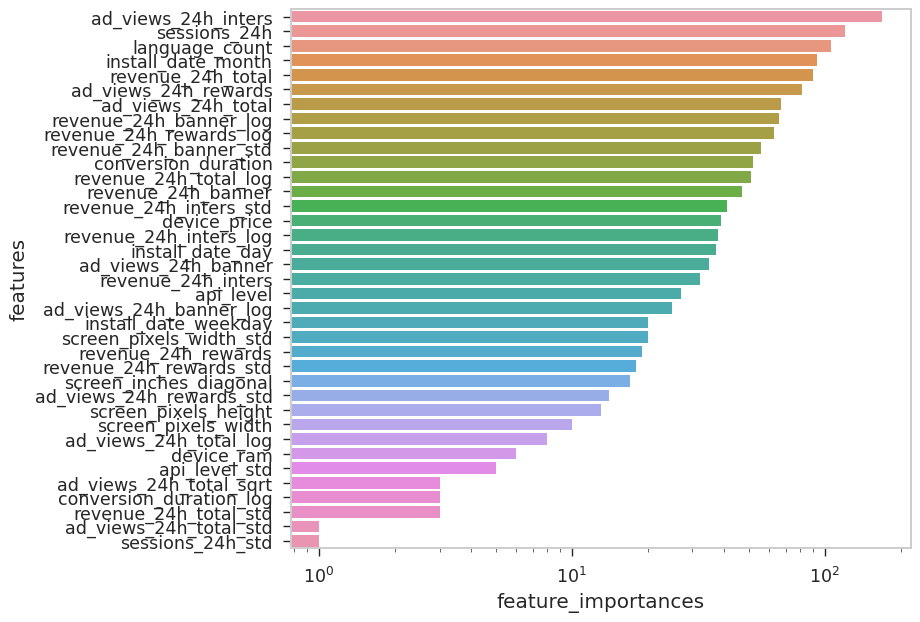

<Figure size 800x700 with 0 Axes>

In [14]:
## Выведем фичи, значения которых максимально вносят вклад в модель, логично, что это все revenue
f_imp_list_cut = f_imp_list_cut.sort_values('feature_importances', ascending=False) 
sns.barplot(f_imp_list_cut['feature_importances'], f_imp_list_cut['features']).set(xscale="log")  
plt.figure()  
plt.show() 
sns.set (font_scale=0.7)

In [15]:
 # Удалим фичи с нулевыми весами по feature_importance из тренировочной и тестовой выборок.
columns_mask = (lgb.feature_importances_ != 0)
x_train_clear = x_train[x_train.columns[columns_mask]]
x_test_clear = x_test[x_test.columns[columns_mask]]

In [17]:
del lgb
!pip install lightgbm
import lightgbm as lgb

In [18]:
 # Заново обучите модель и измерьте качество.
x_train_clear, x_test_clear, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lgb_params = {"n_estimators": 500,
               "max_depth": 5,
               "n_jobs": -1,
               "random_state": 128,
              }

lgb = lgb.LGBMRegressor(**lgb_params)
lgb.fit(x_train_clear, y_train,
              early_stopping_rounds=20, 
              eval_set=[(x_train_clear, y_train), (x_test_clear, y_test)],
              verbose=15)



[15]	training's l2: 0.508991	valid_1's l2: 0.527053
[30]	training's l2: 0.481179	valid_1's l2: 0.502642
[45]	training's l2: 0.471994	valid_1's l2: 0.500058
[60]	training's l2: 0.466292	valid_1's l2: 0.500101


LGBMRegressor(max_depth=5, n_estimators=500, random_state=128)

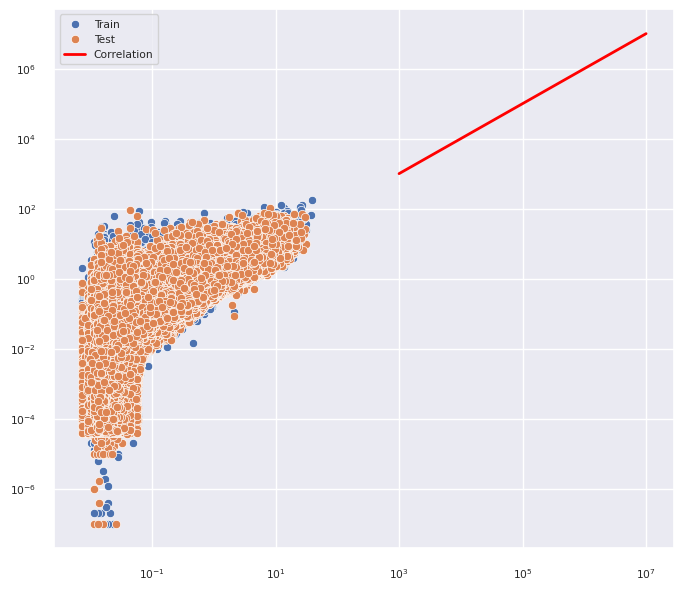

In [19]:
sns.scatterplot(x=lgb.predict(x_train_clear), y=y_train.values).set(xscale="log", yscale="log")
sns.scatterplot(x=lgb.predict(x_test_clear), y=y_test.values).set(xscale="log", yscale="log")
plt.plot([1e3, 1e7], [1e3, 1e7], 'red', linewidth=2)
plt.legend(labels=['Train', 'Test', 'Correlation'])
plt.show()

In [ ]:
gb_std = np.sqrt(mean_squared_error(y_train, lgb.predict(x_train)))
gb_std

# извлечем из модели колонку предсказание выручки
сделаем df состоящий из актуальнйо выручки, предсказанной и ошибки, которую по заданию необходимо оценить
видим, что по статистике предсказине имеет большую ошибку на максим значений (порядок сильно разница и на минимальных)

In [20]:
pred=lgb.predict(x_train_clear)

In [21]:
#извлечем колонку со значениями predict 
pred=pd.DataFrame({"prediction": pred})
pred_df = pd.merge(train['revenue_30d_total'], pred, left_index=True, right_index=True)
#запишем его в датафрейм по формуле (predicted_revenue_30d_total - revenue_30d_total) / revenue_30d_total
pred_df['relev_error']=(pred_df['prediction']-pred_df['revenue_30d_total'])/(pred_df['revenue_30d_total'])

In [22]:
#продублируем и посмотрим это же значением. если брать абсолютные значения, можно ли избежать деления на 0
import numpy as np

def relev_error(A, F):
    with np.errstate(divide='ignore', invalid='ignore'):
        tmp = (np.abs(A) - np.abs(F)) / np.abs(F)
    
    return tmp

print('relev_error прогноза выручки =',relev_error(pred_df.prediction, pred_df.revenue_30d_total))


relev_error прогноза выручки = 0                inf
1           3.484873
2          -0.843606
3           0.268009
4           0.674225
             ...    
2887994    24.140180
2887995    -0.890393
2887996          inf
2887997     3.768110
2887998     0.468624
Length: 2887999, dtype: float64


In [23]:
#запишем полученное значение relev_error в датасет
rel_error=relev_error(pred_df.prediction, pred_df.revenue_30d_total)
pred_error=pd.DataFrame({"relev_error_formule": rel_error})
pred_error_df = pd.merge(pred_df, pred_error, left_index=True, right_index=True)
#заменим значения inf на 0
pred_error_df.loc[pred_error_df['relev_error_formule'] > 180, 'relev_error_formule'] = pred_error_df['relev_error_formule'].apply(lambda x: 0)
pred_error_df.loc[pred_error_df['relev_error'] > 180, 'relev_error'] = pred_error_df['relev_error'].apply(lambda x: 0)

In [24]:
#также расчитаем значением smape Symmetric mean absolute percentage error менее чувствителен к 0 значениям

import numpy as np

def smape(A, F):
    with np.errstate(divide='ignore', invalid='ignore'):
        tmp = 2 * np.abs(F-A) / (np.abs(A) + np.abs(F))
    tmp[np.isnan(tmp)] = 0
    return tmp
print('smape прогноза выручки =',smape(pred_df.prediction, pred_df.revenue_30d_total))

smape прогноза выручки = 0          2.000000
1          1.270721
2          1.459027
3          0.236338
4          0.504239
             ...   
2887994    1.846979
2887995    1.604880
2887996    2.000000
2887997    1.306532
2887998    0.379664
Length: 2887999, dtype: float64


In [25]:
#запишем полученное значение smape в датасет
smape_f=smape(pred_df.prediction, pred_df.revenue_30d_total)
smape_df=pd.DataFrame({"smape_error": smape_f})
pred_error_df = pd.merge(pred_error_df, smape_df, left_index=True, right_index=True)

# Оценка метрики контроля качества на линейной модели train данные

In [26]:
pd.options.display.float_format = '{:.5f}'.format
pred_error_df.describe()

,revenue_30d_total,prediction,relev_error,relev_error_formule,smape_error
count,2887999.00000,2887999.00000,2887999.00000,2887999.00000,2887999.00000
mean,0.20299,0.17664,7.41275,7.41275,1.31841
std,1.05468,0.60382,22.13789,22.13789,0.62263
min,0.00000,0.00747,-0.99990,-0.99990,0.00000
25%,0.00350,0.01687,-0.57514,-0.57514,0.81149
50%,0.01985,0.03248,0.00000,0.00000,1.48156
75%,0.08597,0.10371,3.54256,3.54256,1.90616
max,178.39592,39.55039,179.99980,179.99980,2.00000


(0.0, 10.0)

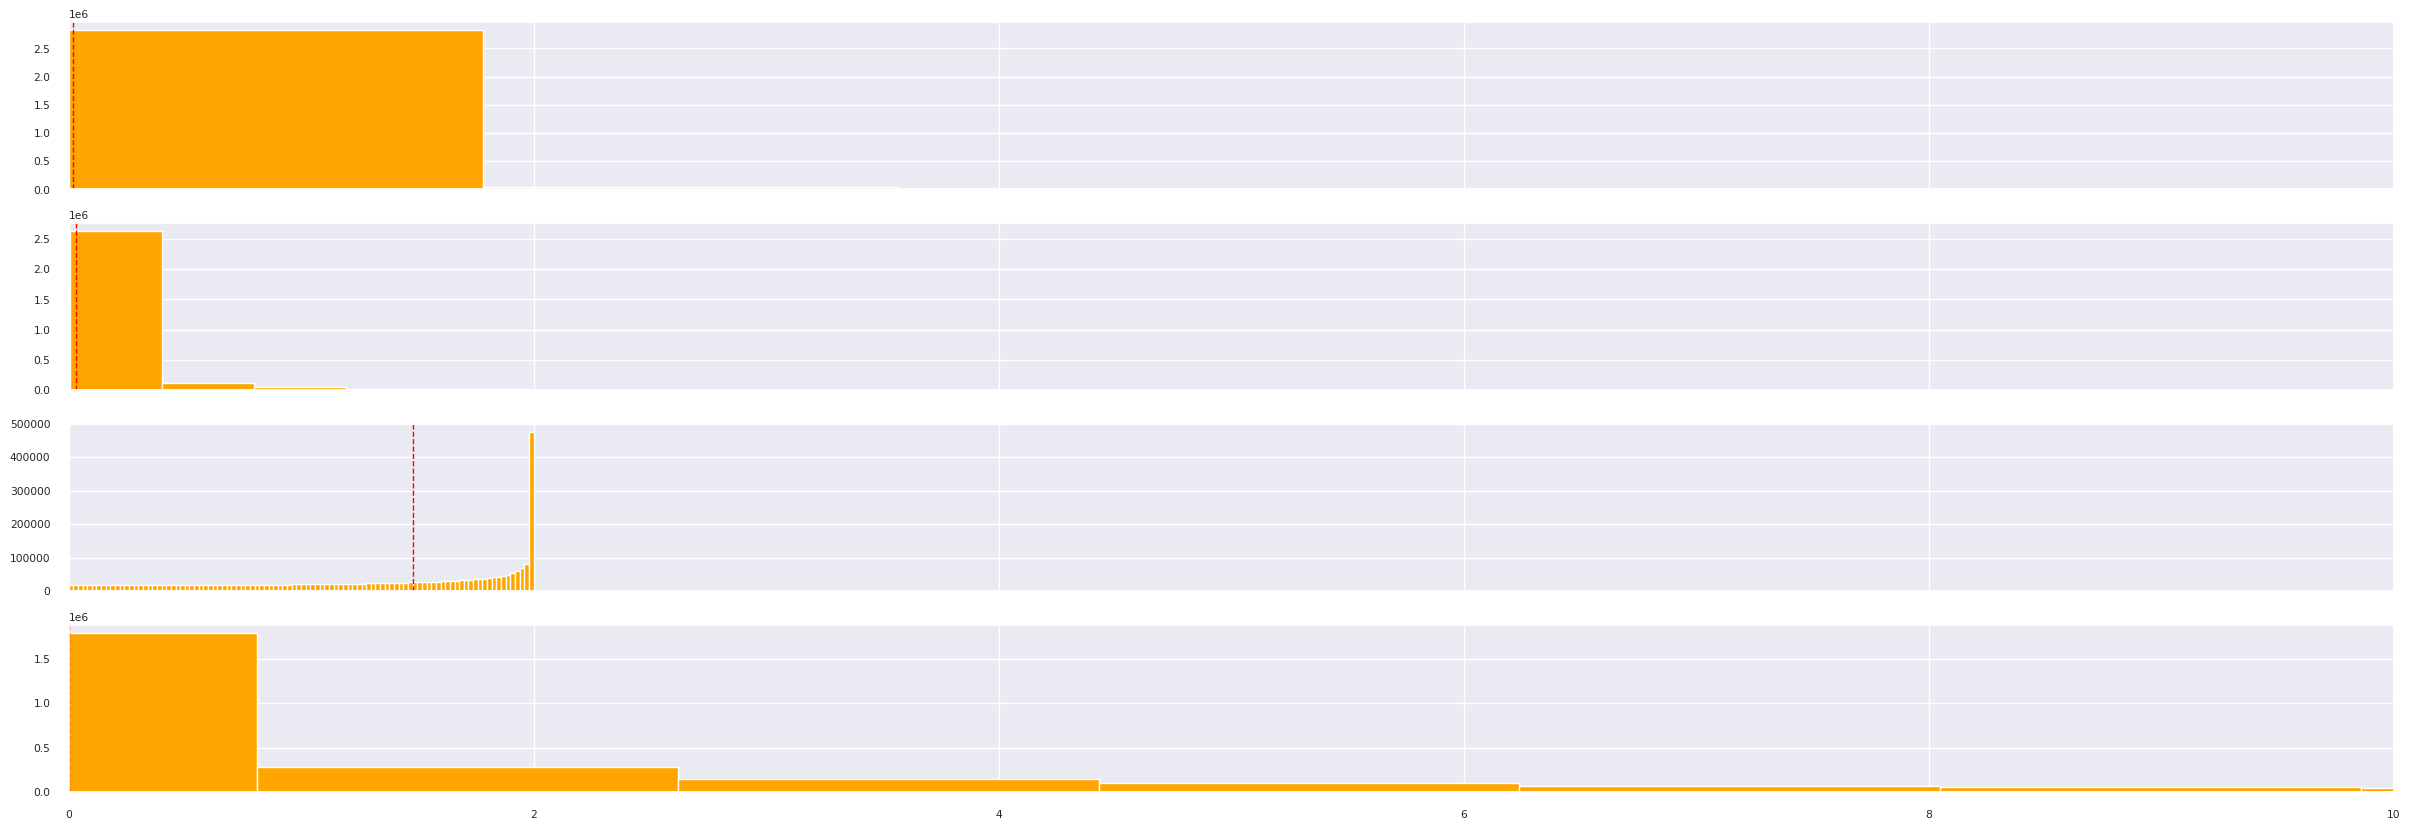

In [27]:
from matplotlib.ticker import FormatStrFormatter
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(30, 10), sharex=True)

ax1.hist(pred_error_df.revenue_30d_total, bins=100, color='orange')
ax1.axvline(pred_error_df.revenue_30d_total.median(), color='red', linestyle='dashed', linewidth=1)

ax2.hist(pred_error_df.prediction, bins=100, color='orange')
ax2.axvline(pred_error_df.prediction.median(), color='red', linestyle='dashed', linewidth=1)


ax3.hist(pred_error_df.smape_error, bins=100, color='orange')
ax3.axvline(pred_error_df.smape_error.median(), color='red', linestyle='dashed', linewidth=1)


ax4.hist(pred_error_df.relev_error_formule, bins=100, color='orange')
ax4.axvline(pred_error_df.relev_error_formule.median(), color='red', linestyle='dashed', linewidth=1)

ax1.set_xlim([0, 10])

# Прогон модели на тестовом файле test.csv



In [28]:
pred_lgb = lgb.predict(x_train)
pred_lgb=pd.DataFrame({"prediction": pred_lgb})
pred_lgb_df = pd.merge(train['revenue_30d_total'], pred_lgb, left_index=True, right_index=True)
pred_lgb_df['relev_error']=(pred_lgb_df['prediction']-pred_lgb_df['revenue_30d_total'])/(pred_lgb_df['revenue_30d_total'])
pd.options.display.float_format = '{:.5f}'.format
pred_lgb_df[['revenue_30d_total','prediction', 'relev_error']].describe()

,revenue_30d_total,prediction,relev_error
count,2887999.00000,2887999.00000,2887999.00000
mean,0.20299,0.17672,inf
std,1.05468,0.60468,NaN
min,0.00000,0.00747,-0.99990
25%,0.00350,0.01687,-0.57602
50%,0.01985,0.03248,1.38343
75%,0.08597,0.10366,23.14727
max,178.39592,39.55039,inf


In [29]:
pred_lgb_df.relev_error. median () 

1.3834331090575591

In [30]:
test = pd.read_csv(path + 'test_out_outliers.csv')
test['install_date'] = pd.to_datetime(test.install_date, utc=True)
test['install_date_weekday'] = test['install_date'].dt.weekday
# добавим новые фичи (частота встречаемости языка)
lan = test['language'].value_counts().reset_index().set_axis(['language', 'language_count'], axis=1)
test = pd.merge(test, lan, how='left', on='language')

In [31]:
test = sqr_sqrt_log_features_transform(test, 
                                       sqr_miss=['revenue_30d_total'],
                                       sqrt_miss=['revenue_30d_total'],
                                       log_miss=['revenue_30d_total'],
                                     )
test = test.drop(['install_date', 'random_user_id','Android', 'language'], axis=1)

In [32]:
for_stand_test=test[['revenue_24h_rewards', 'revenue_24h_total', 'revenue_24h_banner', 'revenue_24h_inters',
'api_level', 'sessions_24h', 'screen_inches_diagonal', 'ad_views_24h_rewards', 'ad_views_24h_total',
'device_price', 'screen_pixels_width', 'conversion_duration']]
std_scaler.fit(for_stand_test)

print('Среднее:', std_scaler.mean_)
print('Дисперсия', std_scaler.var_)
std_scaled = std_scaler.transform(for_stand_test)

Среднее: [1.77389461e-02 7.43703274e-02 9.82544462e-03 4.68059367e-02
 2.92077053e+01 1.74607786e+00 6.46716110e+00 2.17283474e+00
 3.27579578e+01 1.68546564e+02 8.56665191e+02 1.11462244e+04]
Дисперсия [7.76183950e-03 7.36750131e-02 1.45811014e-03 3.14187990e-02
 3.16836849e+00 1.60452087e+00 3.50436092e-01 3.06387177e+01
 4.38151621e+03 6.98845178e+04 5.77948483e+04 5.39152965e+09]


In [33]:
# запишем новые значение стандартизированных данных (взяты из модели baseline после первой прогонки)
# это топ фич по вкладу в модель
test[['revenue_24h_total_std', 'revenue_24h_banner_std', 'revenue_24h_inters_std',
        'revenue_24h_rewards_std', 'ad_views_24h_total_std',
        'ad_views_24h_rewards_std', 'sessions_24h_std',
        'conversion_duration_std', 'api_level_std', 'device_price_std',
        'screen_inches_diagonal_std','screen_pixels_width_std' 
        ]] = for_stand_test  


In [34]:
test = test.drop(['revenue_30d_total'], axis=1)

In [35]:
pred = lgb.predict(test)

In [36]:
pred=pd.DataFrame({"prediction": pred})
pred_df = pd.merge(test, pred, left_index=True, right_index=True)


In [37]:
print('mean значений реальных данных =',pred. mean ()) 
print('median значений прогноз данных =',pred. median ()) 

mean значений реальных данных = prediction   0.17184
dtype: float64
median значений прогноз данных = prediction   0.07176
dtype: float64


(0.0, 5.0)

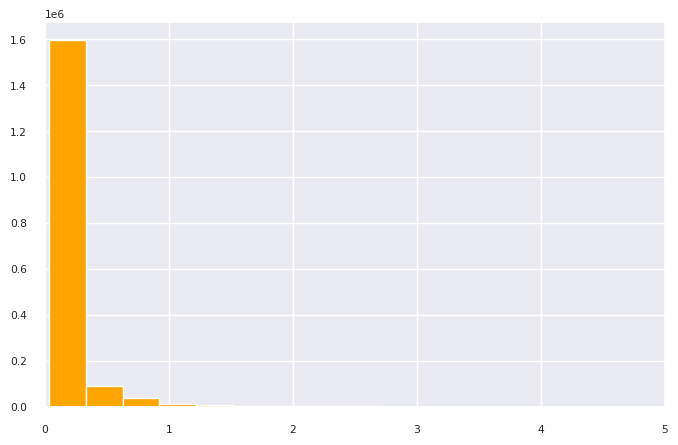

In [38]:
plt.figure(figsize=(8, 5))

plt.hist(pred, bins=100, color='orange')
plt.xlim(0, 5)

In [39]:
pred_df['prediction'].describe()

count   1770460.00000
mean          0.17184
std           0.41622
min           0.03192
25%           0.05927
50%           0.07176
75%           0.13191
max          29.75212
Name: prediction, dtype: float64

In [40]:
# подготовим абсолютный путь до папки с данными
path = os.path.expanduser('~/PycharmProjects/Brightika_test/')
pred_df.to_csv(path + 'test_tosend_LGBMRegr.csv', index=False)